In [1]:
from pathlib import Path

import idx2numpy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'numpy version: {np.__version__}')
print(f'idx2numpy version: {idx2numpy.__version__}')

torch version: 1.8.1+cu102
torchvision version: 0.9.1+cu102
numpy version: 1.22.3
idx2numpy version: 1.2.3


In [2]:
project_path = Path.cwd().parent
project_path
data_dir = project_path / 'data' / 'fashion_mnist'

## Original FashionMNIST Dataset

In [3]:

train_im_file = data_dir / 'train-images-idx3-ubyte'
train_label_file = data_dir / 'train-labels-idx1-ubyte'
test_im_file = data_dir / 't10k-images-idx3-ubyte'
test_label_file = data_dir / 't10k-labels-idx1-ubyte'

In [4]:
train_ims = idx2numpy.convert_from_file(str(train_im_file))
train_labels = idx2numpy.convert_from_file(str(train_label_file))
test_ims = idx2numpy.convert_from_file(str(test_im_file))
test_labels = idx2numpy.convert_from_file(str(test_label_file))
type(train_ims)

numpy.ndarray

In [5]:
print(f"{train_ims.shape = }")
print(f"{train_labels.shape = }")
print(f"{test_ims.shape = }")
print(f"{test_labels.shape = }")

train_ims.shape = (60000, 28, 28)
train_labels.shape = (60000,)
test_ims.shape = (10000, 28, 28)
test_labels.shape = (10000,)


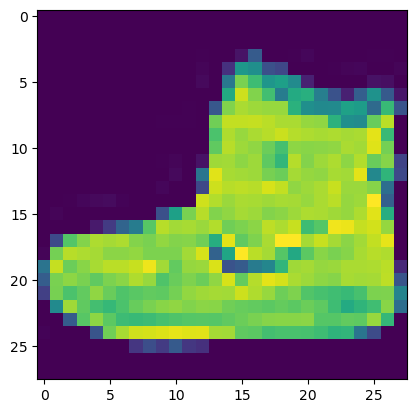

In [6]:
mean = np.mean(train_ims)
std = np.std(train_ims)
im0 = train_ims[0]
im0 = (im0 - mean) / std
train_ims_norm = (train_ims - mean) / std
plt.imshow(train_ims_norm[0], cmap='gray')

In [7]:
labels = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

Label: Dress


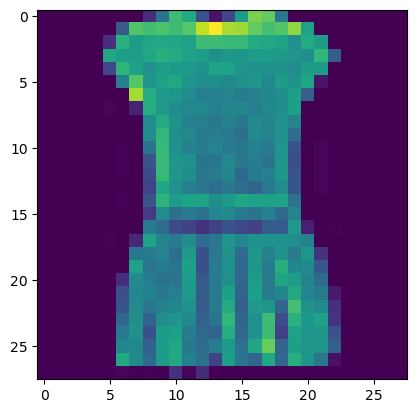

In [8]:
indx = 3
plt.imshow(train_ims[indx])
print(f"Label: {labels[train_labels[indx]]}")

In [9]:
class OriginalFashionMNIST(Dataset):
    def __init__(self, train_ims: np.ndarray, 
                       train_labels: np.ndarray, 
                       test_ims: np.ndarray,
                       test_labels: np.ndarray,
                       train: bool = True):
        if train:
            self.ims = train_ims
            self.labels = train_labels
        else:
            self.ims = test_ims
            self.labels = test_labels

        self.normalize()
        self.ims = torch.tensor(self.ims, dtype=torch.float)
        self.ims = torch.unsqueeze(self.ims, dim=1)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def normalize(self):
            """
            subtracts from each image the mean
            and divides by the standard deviation (second number)
            """
            mean = np.mean(self.ims)
            std = np.std(self.ims)
            self.ims = (self.ims - mean) / std

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, index):
        return self.ims[index], self.labels[index]


In [10]:
fmnist_train = OriginalFashionMNIST(train_ims, train_labels, test_ims, test_labels)
fmnist_test = OriginalFashionMNIST(train_ims, train_labels, test_ims, test_labels, train=False)

In [11]:
print(f"len of the train dataset: {len(fmnist_train)}")
print(f"len of the test dataset: {len(fmnist_test)}")

len of the train dataset: 60000
len of the test dataset: 10000


In [12]:
train_loader = DataLoader(fmnist_train, 
                          batch_size = 64, 
                          shuffle = True)
test_loader = DataLoader(fmnist_test, 
                          batch_size = 64, 
                          shuffle = True)

In [13]:
data_iter = iter(test_loader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


### The linear model

In [14]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        y_pred = self.linear(x)
        y_pred = self.softmax(y_pred)
        return y_pred

### Train and test

In [30]:
lr_model = LinearModel(784, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr_model.parameters(), lr = 0.002)
epochs = 20

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0

    # training pass
    for images, labels in train_loader:
        # set the gradients to 0
        optimizer.zero_grad()
        # flatten the Fashion-MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        # the forward pass
        output = lr_model(images)  # get the output
        loss = criterion(output, labels)  # calculate the loss
        running_loss += loss.item()
        # the backward pass
        loss.backward()  # get the gradients
        optimizer.step()  # update the weights
    
    # test pass
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        # Set the model to evaluation mode
        lr_model.eval()
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            output = lr_model(images)
            test_loss += criterion(output, labels)
            top_p, top_class = output.topk(1, dim = 1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(train_loader)),
          "Test loss: {:.3f}..".format(test_loss/len(test_loader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

/tmp/ipykernel_14055/1454682819.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = self.softmax(y_pred)


Epoch: 1/20.. Training loss: 1.662.. Test loss: 1.635.. Test Accuracy: 0.831
Epoch: 2/20.. Training loss: 1.622.. Test loss: 1.636.. Test Accuracy: 0.827
Epoch: 3/20.. Training loss: 1.613.. Test loss: 1.626.. Test Accuracy: 0.838
Epoch: 4/20.. Training loss: 1.609.. Test loss: 1.626.. Test Accuracy: 0.836
Epoch: 5/20.. Training loss: 1.606.. Test loss: 1.622.. Test Accuracy: 0.838
Epoch: 6/20.. Training loss: 1.604.. Test loss: 1.619.. Test Accuracy: 0.844
Epoch: 7/20.. Training loss: 1.602.. Test loss: 1.621.. Test Accuracy: 0.841
Epoch: 8/20.. Training loss: 1.600.. Test loss: 1.618.. Test Accuracy: 0.844
Epoch: 9/20.. Training loss: 1.598.. Test loss: 1.617.. Test Accuracy: 0.844
Epoch: 10/20.. Training loss: 1.598.. Test loss: 1.619.. Test Accuracy: 0.841
Epoch: 11/20.. Training loss: 1.597.. Test loss: 1.618.. Test Accuracy: 0.844
Epoch: 12/20.. Training loss: 1.595.. Test loss: 1.620.. Test Accuracy: 0.841
Epoch: 13/20.. Training loss: 1.594.. Test loss: 1.618.. Test Accuracy: 0

## Quantized FashionMNIST Dataset